In [1]:
from huggingface_hub import snapshot_download

In [2]:
dataset_path = snapshot_download(repo_id="biglab/webui-7k", repo_type="dataset")
dataset_path

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

'/home/flynn/.cache/huggingface/hub/datasets--biglab--webui-7k/snapshots/60f7b3c4b9409f75551664adc1564625dfc33c2e'

In [3]:
import enum
import os
import zipfile
import gzip
import json
from glob import glob
import re

In [4]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# dead code
class WidType(enum.StrEnum):
    IMG = "img",
    FIGURE = "figure",
    S_TEXT = "StaticText",
    SEP = "separator",
    BR = "LineBreak", # <br>
    LINK = "link",
    LIST_ITEM = "listitem",
    HEADING = "heading",
    PARAGRAPH = "paragraph"



In [5]:
# Create output dir
d1_path = os.path.join(dataset_path, "dataset1")
if not os.path.exists(d1_path):
    os.mkdir(d1_path)

## Dataset decompression

In [ ]:
# Merge 2 zip files
files = glob(os.path.join(dataset_path, "*.zip*"))
output = os.path.join(d1_path, "dataset.zip")

os.system("cat " + ' '.join(files) + " > " + output)

0

In [ ]:
d1_zip = os.path.realpath(output)
zipfile.is_zipfile(d1_zip)

True

In [ ]:
with zipfile.ZipFile(output, 'r') as z:
    z.extractall(d1_path)

## Loading files

In [6]:
files = os.path.join(d1_path, "train_split_web7k")

In [7]:
files

'/home/flynn/.cache/huggingface/hub/datasets--biglab--webui-7k/snapshots/60f7b3c4b9409f75551664adc1564625dfc33c2e/dataset1/train_split_web7k'

In [ ]:
len(os.listdir(files))

5420

In [8]:
# Load pages metadata
with open('webui/metadata/screenclassification/class_map_enrico.json', 'r') as f:
    labels = json.load(f)["idx2Label"].values()
dtypes = {**{'page_id': object, 'file': object}, **dict([(x, np.float64) for x in labels])}

df_c = pd.read_csv('webui/metadata/screenclassification/silver_webui-multi_topic.csv', sep=r'[,\\]', names=['page_id', 'file', *labels], dtype=dtypes, engine='python')

In [41]:
def label_certainty_thresh(c: np.float64) -> bool:
    return c >= 6.0

In [24]:
#df_c_max.apply(lambda x: x[[*labels]].max(), axis=1).mean()
#-np.log(0.5)

In [43]:
# Take average of each screenshot and save max
df_c_max = df_c.drop(columns='file').groupby(by=df_c['page_id'])[[*labels]].mean()
#df_c_max['label_max'] = df_c_max.apply(lambda x: x[labels].idxmax(), axis=1)
#df_c_max['certainty'] = df_c_max.apply(lambda x: x[labels].max(), axis=1)

df_c_max[['label_max', 'certainty']] = df_c_max.apply(lambda x: (x[labels].idxmax(), x[labels].max()), axis=1).apply(pd.Series)
df_c_max.index = df_c_max.index.astype(np.int64)

In [10]:
df_c_max["label_max"].value_counts()

label_max
tutorial       42840
news           16402
gallery        14682
list           13933
modal          10268
menu           10037
terms           7995
profile         6242
bare            5960
login           5665
mediaplayer     4961
calculator      1626
search          1250
other           1249
form            1135
camera           907
settings         766
editor           365
chat             143
maps             140
Name: count, dtype: int64

## Dataset parsing

In [39]:
class FileType(enum.StrEnum):
    """
    Enum containing all filetypes
    """

    AXTree = "axtree.json.gz",
    BB = "bb.json.gz",
    Box = "box.json.gz",
    Class = "class.json.gz",
    HTML = "html.html",
    Links = "links.json",
    ScreenFull = "screenshot-full.webp",
    Screen = "screenshot.webp",
    Style = "style.json.gz",
    URL = "url.txt",
    Viewport = "viewport.json.gz"

# Helper functions

def ft_is_gz(ft: FileType) -> bool:
    """
    Check if a FileType is a gz file
    """
    return ft in [FileType.AXTree, FileType.BB, FileType.Box, FileType.Class, FileType.Style, FileType.Viewport]

def ft_is_json(ft: FileType) -> bool:
    """
    Check if a FileType is in json format
    """
    return ft in [FileType.AXTree, FileType.BB, FileType.Box, FileType.Class, FileType.Links, FileType.Style, FileType.Viewport]

def ft_is_webp(ft: FileType) -> bool:
    """
    Check if a FileType is a webp image
    """
    return ft in [FileType.ScreenFull, FileType.Screen]





class Page():
    """
    A class which loads page content (screen)
    """
    def __init__(self, path, screen_type: str, debug: bool = True):
        self.screen_type = screen_type
        self.path = path
        self.skip = False

        # Parse screen type
        self.desktop = screen_type.startswith("default")
        if self.desktop:
            (self.width, self.height) = tuple(map(int, screen_type.split('_')[1].split('-')))
        else:
            (self.width, self.height) = (0, 0)

        # Load filenames
        #files = list(filter(lambda x: x.startswith(screen_type), os.listdir(path)))
        self.fnames = dict()
        self.files = dict()
        missing = False

        for ft in FileType:
            file_path = screen_type + "-" + ft.value
            if os.path.exists(os.path.join(self.path, file_path)):
                self.fnames[ft] = file_path
            else:
                missing = True


        if missing:
            # Some files are missing
            if debug:
                for ft, v in self.fnames.items():
                    assert ft_is_webp(ft), "Page::__init__() : non-webp file in partial download : {}".format(v)
            self.skip = True


    def load(self, debug: bool = True, *args):
        if self.skip:
            return

        if len(args) == 0:
            ftypes = FileType
        else:
            ftypes = args

        for ft in ftypes:
            fname = os.path.join(self.path, self.fnames[ft])
            if debug:
                print("Page::load() : loading file {}...".format(self.fnames[ft]))

            if ft_is_webp(ft):
                # Check if the file is empty
                if os.path.getsize(fname) == 0:
                    if debug:
                        print("Page::load() : {} is empty".format(self.fnames[ft]))
                    continue
                self.files[ft] = Image.open(fname)

            elif ft_is_gz(ft):
                # gzip
                with gzip.open(fname) as f:
                    if ft_is_json(ft):
                        self.files[ft] = json.load(f)
                    else:
                        # plaintext
                        self.files[ft] = f.read()
            else:
                # not compressed
                with open(fname) as f:
                    if ft_is_json(ft):
                        self.files[ft] = json.load(f)
                    else:
                        # plaintext
                        self.files[ft] = f.read()


class PageLoader():
    """
    A class which loads multiple pages (with different resolutions). Loads only labels of the specified class
    """
    def __init__(self, path, debug: bool = True, *args):
        self.path = path
        self.page_id = np.int64(os.path.basename(path))

        #print(self.page_id)
        self.label = df_c_max.at[self.page_id, "label_max"]
        self.certainty = df_c_max.at[self.page_id, "certainty"]

        self.skip = False

        if debug:
            print("PageLoader()::__init__() : opening", self.page_id)
            #print(os.listdir(self.path))

        # Extract pages
        prefixes = map(lambda x: '-'.join(x.split('-')[:-1]), os.listdir(self.path))
        screen_types = list(filter(lambda x: x.find("screenshot") == -1, list(set(prefixes))))

        self.pages = dict()

        for s in screen_types:
            page = Page(self.path, s, debug)
            if not page.skip:
                self.pages[s] = page
                self.pages[s].load(debug) # load all

    def image(self) -> [Image.Image, None]:
        """
        Find and return the largest page image width. Desktop images always have the largest priority
        """
        for page in sorted(list(self.pages.values()), reverse=True, key=lambda x: x.width):
            if page.files.get(FileType.Screen) is not None:
                return page.files[FileType.Screen]
        return None

In [29]:
def preview(img: Image.Image, width: int) -> Image.Image:
    return img.resize((width, int(img.height / img.width * width)))

In [45]:
_ = plt.figure(figsize=(36, 20)) # 1920/1080 scaled to 360p
(nrows, ncols) = (5, 5) # Set the grid size
start = nrows*ncols # Start index
skip = 0

files_l = os.listdir(files)
for index in range(0, nrows*ncols):
    while True: # Find matching
        fpath = files_l[index + start + skip]
        # Parse the page
        loader = PageLoader(os.path.join(files, fpath), debug=False)
        if not label_certainty_thresh(loader.certainty):
            skip += 1
            continue # Skip

        # Create a subplot and render an image
        ax = plt.subplot(nrows, ncols, index+1)
        _ = plt.title(loader.label)
        _, _ = plt.xticks([]), plt.yticks([]);
        image = loader.image()
        if image is not None:
            _ = plt.imshow(preview(image, 360))
        else:
            skip += 1
            continue # Load the next sample

        # Else found
        break
_ = plt.show()


KeyboardInterrupt



<Figure size 3600x2000 with 0 Axes>

In [ ]:
loader.pages['default_1920-1080'].files[FileType.AXTree]["nodes"].__len__()

649

1656338082813 list


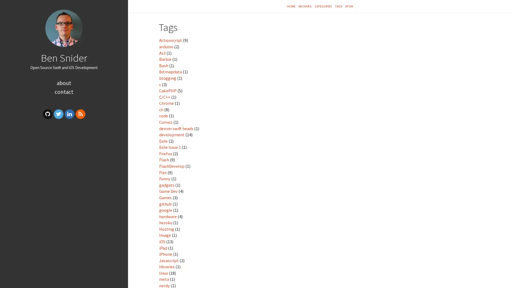

In [ ]:
print(loader.page_id, loader.label)
display(preview(loader.pages['default_1920-1080'].files[FileType.Screen], 512))